# OBJECTIVE 
1.update the base model

2.Use less parameter 

3.Achieve decent accuracy 

4. EXTRA Added 

batchnorm 2d  best train:99.49
              best test :99.39
            
add batchnorm and drop out 
              best train :98.95
              best test :99.13

In [25]:
# Import Libraries

In [26]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [27]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [28]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [29]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


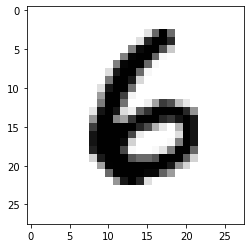

In [30]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

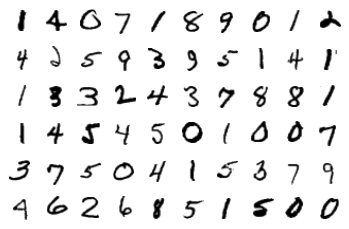

In [31]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [32]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.input_block = nn.Sequential(
      #INPUT 28X28X1 >>CONV 3X3X1X16 >>26X26X16
          nn.Conv2d(1, 14, 3, bias=False), 
          nn.BatchNorm2d(14),
          nn.ReLU(),
          nn.Dropout(0.15),


 
      #INPUT 26X26X16 >>CONV 3X3X16X32 >>24X24X32
          nn.Conv2d(14, 20, 3, bias=False), 
          nn.BatchNorm2d(20),
          nn.ReLU(),
          nn.Dropout(0.1),

      )
            # translation layer
      
      self.trans1 = nn.Sequential(
          #24X24x32 >>CONV 1X1X32X16 >>24X24X16
          nn.Conv2d(20, 10, 1, bias=False), 
    
          nn.ReLU(),
          #24X24x8 >>MAXPOOL (2,2) >>12X12X16
          nn.MaxPool2d(2, 2),
      )
      self.conv_block = nn.Sequential(
           #12X12x8 >>CONV 3X3X8X16 PAD=0 >>10X10X16
          nn.Conv2d(10, 16, 3, bias=False),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.Dropout(0.1),


        #10X10x16 >>CONV 3X3X16X16 >>8X8X16

         nn.Conv2d(16, 16, 3, bias=False),
         nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.Dropout(0.1),

          #8X8x16 >>CONV 3X3X16X16 >>6X6X16

         nn.Conv2d(16, 18, 3, bias=False),
         nn.BatchNorm2d(18),
         
          nn.ReLU(),


      )
              # OUTPUT BLOCK
      self.gap = nn.Sequential(
          nn.AvgPool2d(kernel_size=6)
      ) # output_size = 1

      self.convblockout = nn.Sequential(
          nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          # nn.BatchNorm2d(10),
          # nn.ReLU(),
          # nn.Dropout(dropout_value)
      ) 

    """forward: performs a forward pass when model(x) is called
    Params
        x: the input data
    Returns
        y: the output of the model
    """
    def forward(self, x):
        x = self.input_block(x)
        x = self.trans1(x)
        x = self.conv_block(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [33]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
       BatchNorm2d-2           [-1, 14, 26, 26]              28
              ReLU-3           [-1, 14, 26, 26]               0
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           2,520
       BatchNorm2d-6           [-1, 20, 24, 24]              40
              ReLU-7           [-1, 20, 24, 24]               0
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
             ReLU-10           [-1, 10, 24, 24]               0
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,440
      BatchNorm2d-13           [-1, 16, 10, 10]              32
             ReLU-14           [-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [34]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    tqdm._instances.clear()


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [35]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.19982294738292694 Batch_id=468 Accuracy=79.98: 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2984, Accuracy: 9142/10000 (91.42%)

EPOCH: 1


Loss=0.046394795179367065 Batch_id=468 Accuracy=96.73: 100%|██████████| 469/469 [00:13<00:00, 35.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1023, Accuracy: 9709/10000 (97.09%)

EPOCH: 2


Loss=0.08732781559228897 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:12<00:00, 36.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 9764/10000 (97.64%)

EPOCH: 3


Loss=0.0777931809425354 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9846/10000 (98.46%)

EPOCH: 4


Loss=0.051627401262521744 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:12<00:00, 36.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9877/10000 (98.77%)

EPOCH: 5


Loss=0.029067253693938255 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 35.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9859/10000 (98.59%)

EPOCH: 6


Loss=0.06929486989974976 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.026872577145695686 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9904/10000 (99.04%)

EPOCH: 8


Loss=0.07134759426116943 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9875/10000 (98.75%)

EPOCH: 9


Loss=0.05071277543902397 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 35.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9888/10000 (98.88%)

EPOCH: 10


Loss=0.02542182058095932 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9905/10000 (99.05%)

EPOCH: 11


Loss=0.11268831044435501 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 35.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9914/10000 (99.14%)

EPOCH: 12


Loss=0.01821673847734928 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 35.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9909/10000 (99.09%)

EPOCH: 13


Loss=0.03552531450986862 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.01659611612558365 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 34.71it/s]



Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)



Text(0.5, 1.0, 'Test Accuracy')

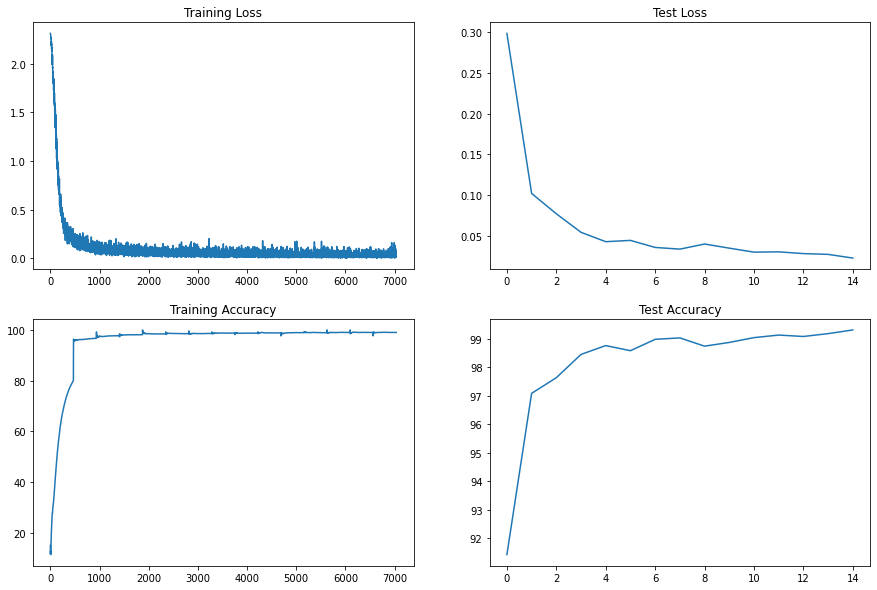

In [36]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")